In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error as MSE, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report

In [2]:
churn=pd.read_csv("churn_clean.csv")
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

In [3]:
#identify missing values
churn.isnull().sum()

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

In [4]:
#identify duplicates
churn.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

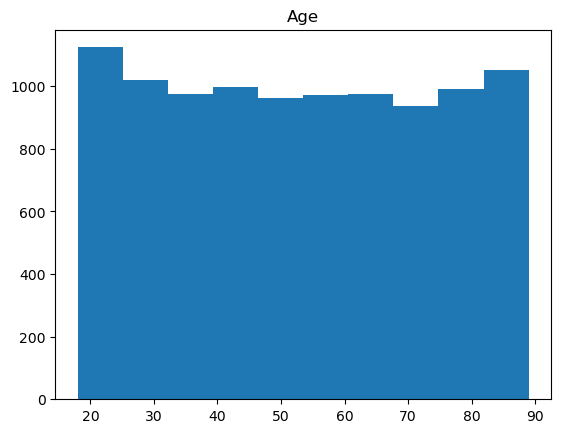

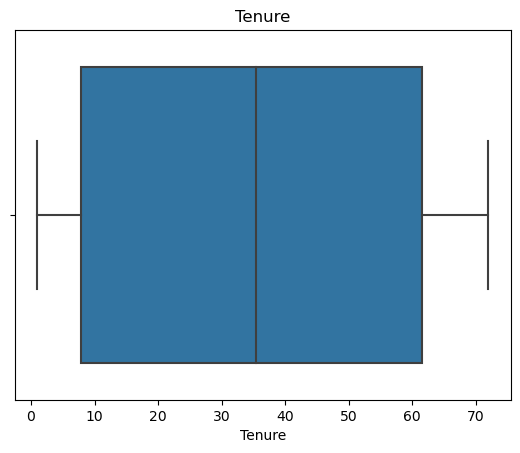

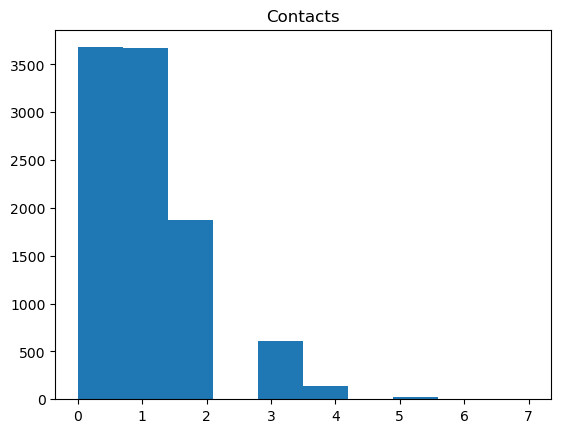

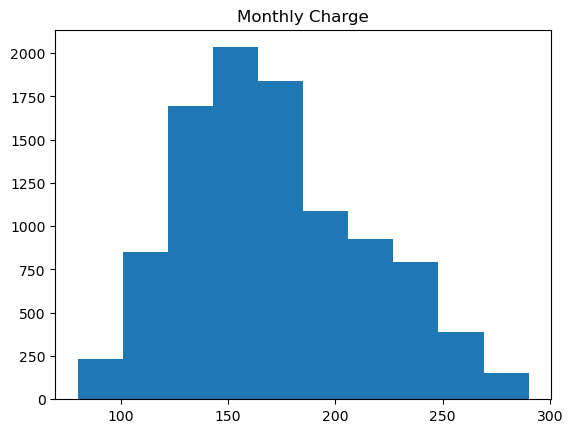

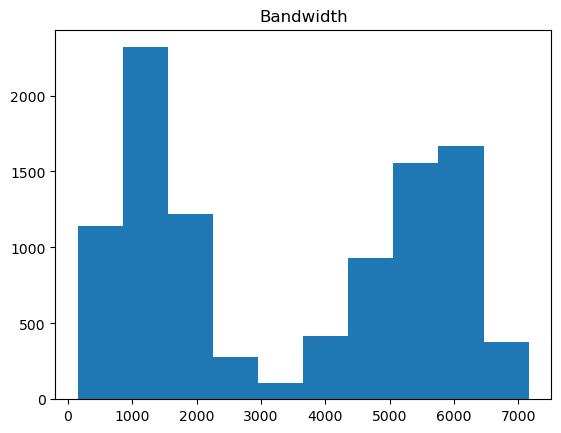

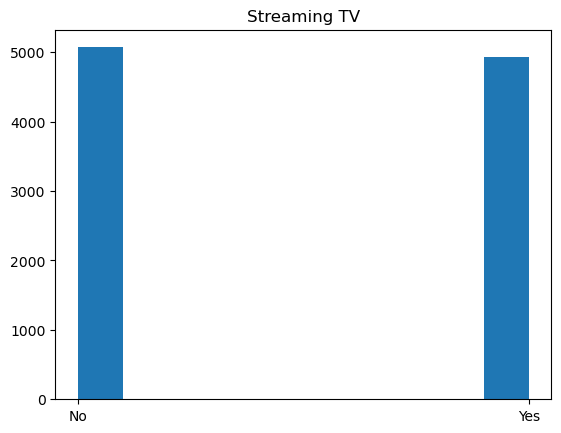

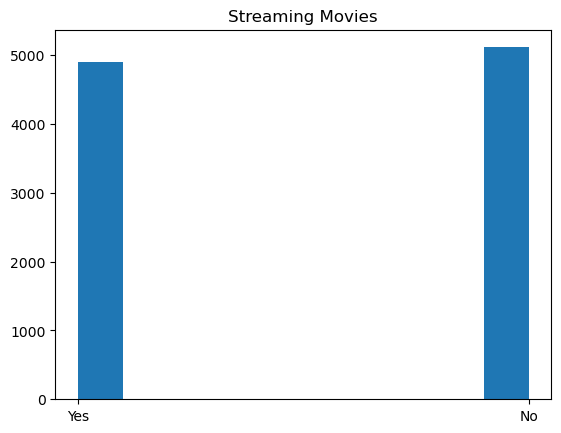

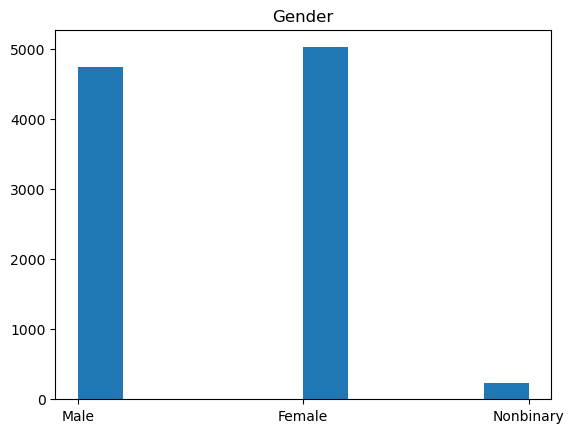

In [5]:
#identify outliers (monthlycharge, tenure, bandwidth, contacts, age, gender, streamingtv, streamingmovies)
plt.hist(churn['Age'])
plt.title("Age")
plt.show()

sb.boxplot(x=churn['Tenure'])
plt.title("Tenure")
plt.show()

plt.hist(x=churn['Contacts'])
plt.title("Contacts")
plt.show()

plt.hist(x=churn['MonthlyCharge'])
plt.title("Monthly Charge")
plt.show()

plt.hist(x=churn['Bandwidth_GB_Year'])
plt.title("Bandwidth")
plt.show()

plt.hist(x=churn['StreamingTV'])
plt.title("Streaming TV")
plt.show()

plt.hist(x=churn['StreamingMovies'])
plt.title("Streaming Movies")
plt.show()

plt.hist(x=churn['Gender'])
plt.title("Gender")
plt.show()

In [6]:
#drop unused columns
churn=churn.drop(['Churn', 'Contract', 'InternetService', 'TechSupport','CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job', 'Children', 'Income', 'Marital', 'Outage_sec_perweek', 'Email', 'Yearly_equip_failure', 'Techie', 'Port_modem', 'Tablet', 'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'PaperlessBilling', 'PaymentMethod', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'], axis=1)
churn.head()

,Age,Gender,Contacts,StreamingTV,StreamingMovies,Tenure,MonthlyCharge,Bandwidth_GB_Year
0,68,Male,0,No,Yes,6.795513,172.455519,904.536110
1,27,Female,0,Yes,Yes,1.156681,242.632554,800.982766
2,50,Female,0,No,Yes,15.754144,159.947583,2054.706961
3,48,Male,2,Yes,No,17.087227,119.956840,2164.579412
4,83,Male,2,Yes,No,1.670972,149.948316,271.493436


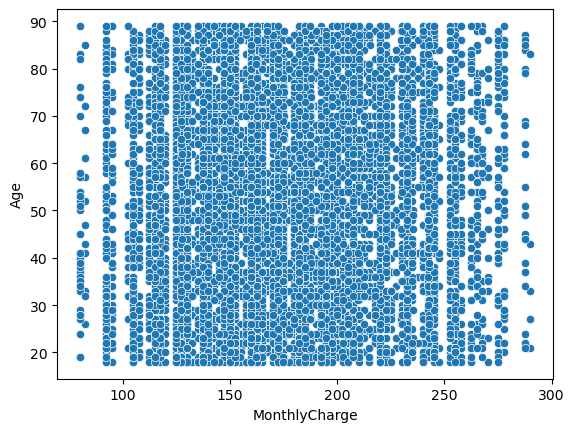

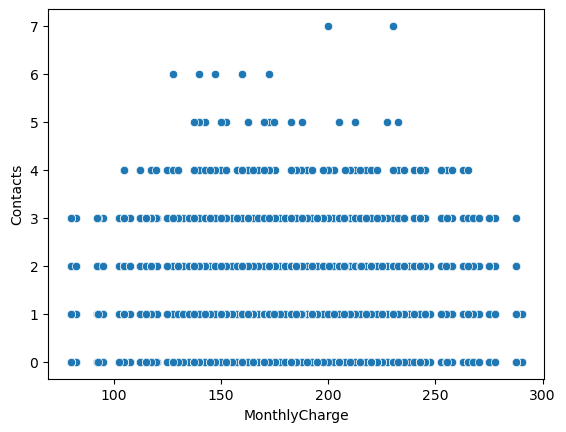

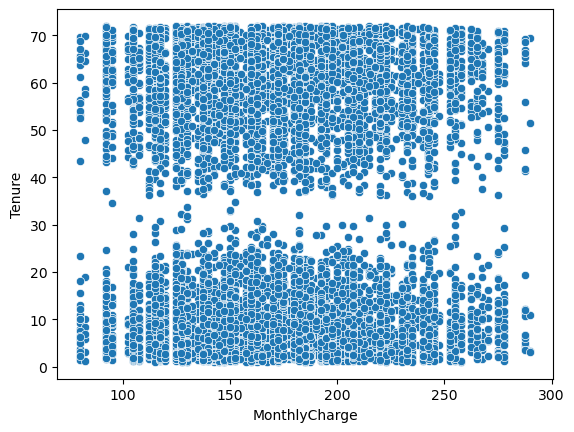

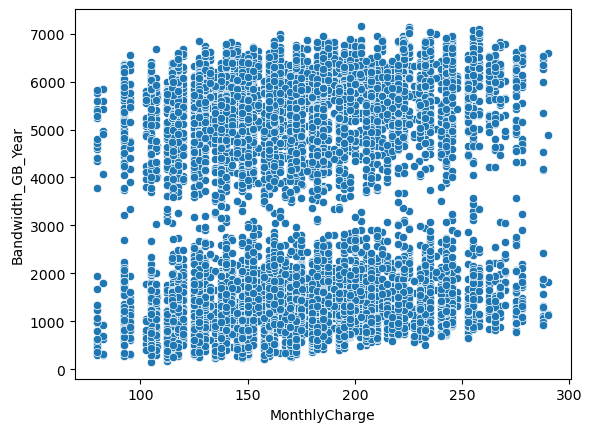

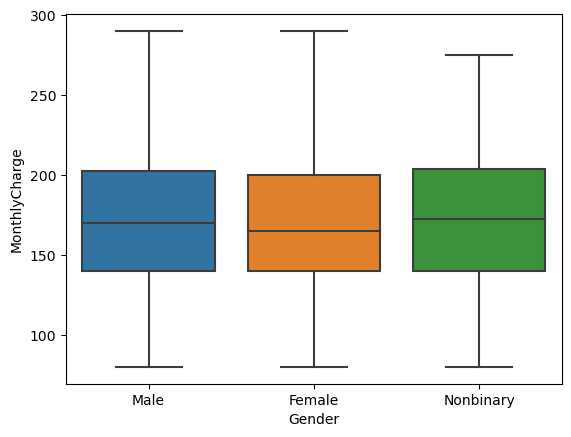

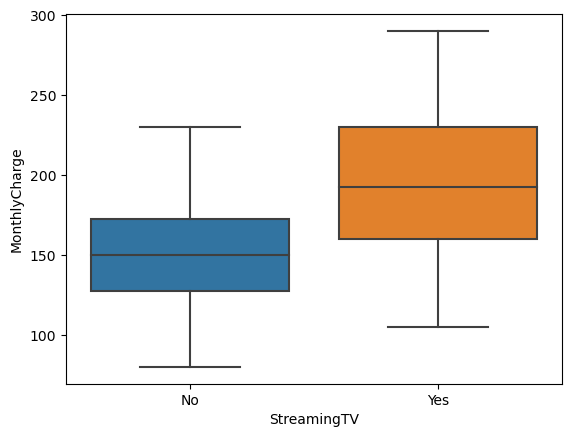

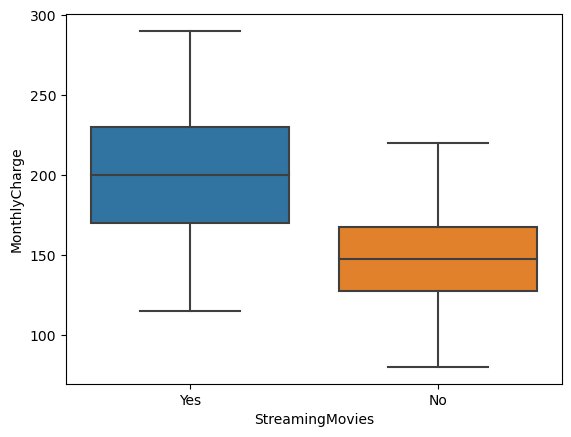

In [7]:
#bivariate graphs
sb.scatterplot(x='MonthlyCharge', y='Age', data=churn)
plt.show()

sb.scatterplot(x='MonthlyCharge', y='Contacts', data=churn)
plt.show()

sb.scatterplot(x='MonthlyCharge', y='Tenure', data=churn)
plt.show()

sb.scatterplot(x='MonthlyCharge', y='Bandwidth_GB_Year', data=churn)
plt.show()

sb.boxplot(x='Gender', y='MonthlyCharge', data=churn)
plt.show()

sb.boxplot(x='StreamingTV', y='MonthlyCharge', data=churn)
plt.show()

sb.boxplot(x='StreamingMovies', y='MonthlyCharge', data=churn)
plt.show()

In [8]:
#reexpress categorical variables
churn['movies']=churn['StreamingMovies']
dict_movies={'movies':{'Yes':1, 'No':0}}
churn.replace(dict_movies, inplace=True)
churn.movies.unique()

array([1, 0])

In [9]:
churn['tv']=churn['StreamingTV']
dict_tv={'tv':{'Yes':1, 'No':0}}
churn.replace(dict_tv, inplace=True)
churn.tv.unique()

array([0, 1])

In [10]:
#reexpression of categorical variables 
gender_dummies=pd.get_dummies(churn['Gender'], prefix='Gender')

#create dummy variables for gender
contacts_dummies=pd.get_dummies(churn['Contacts'], prefix='Contact')

#concatenate the dummy variables with original dataframe
churn=pd.concat([churn, gender_dummies, contacts_dummies], axis=1)

#drop the original internetservice and contract
churn=churn.drop(['Gender', 'Contacts'], axis=1)
churn.head()

,Age,StreamingTV,StreamingMovies,Tenure,MonthlyCharge,Bandwidth_GB_Year,movies,tv,Gender_Female,Gender_Male,Gender_Nonbinary,Contact_0,Contact_1,Contact_2,Contact_3,Contact_4,Contact_5,Contact_6,Contact_7
0,68,No,Yes,6.795513,172.455519,904.536110,1,0,0,1,0,1,0,0,0,0,0,0,0
1,27,Yes,Yes,1.156681,242.632554,800.982766,1,1,1,0,0,1,0,0,0,0,0,0,0
2,50,No,Yes,15.754144,159.947583,2054.706961,1,0,1,0,0,1,0,0,0,0,0,0,0
3,48,Yes,No,17.087227,119.956840,2164.579412,0,1,0,1,0,0,0,1,0,0,0,0,0
4,83,Yes,No,1.670972,149.948316,271.493436,0,1,0,1,0,0,0,1,0,0,0,0,0


In [11]:
#scale numeric features
numeric_features=['Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Age']
scaler=StandardScaler()
churn[numeric_features]=scaler.fit_transform(churn[numeric_features])

In [12]:
#export cleaned dataset
churn.to_csv("Churn_cleaned_Task2.csv")
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                10000 non-null  float64
 1   StreamingTV        10000 non-null  object 
 2   StreamingMovies    10000 non-null  object 
 3   Tenure             10000 non-null  float64
 4   MonthlyCharge      10000 non-null  float64
 5   Bandwidth_GB_Year  10000 non-null  float64
 6   movies             10000 non-null  int64  
 7   tv                 10000 non-null  int64  
 8   Gender_Female      10000 non-null  uint8  
 9   Gender_Male        10000 non-null  uint8  
 10  Gender_Nonbinary   10000 non-null  uint8  
 11  Contact_0          10000 non-null  uint8  
 12  Contact_1          10000 non-null  uint8  
 13  Contact_2          10000 non-null  uint8  
 14  Contact_3          10000 non-null  uint8  
 15  Contact_4          10000 non-null  uint8  
 16  Contact_5          1000

In [13]:
#feature selection & split datasets
X=churn.drop(['MonthlyCharge', 'StreamingTV', 'StreamingMovies'], axis=1)
y=churn['MonthlyCharge']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape, y.shape, X_train.shape, X_test.shape, y_test.shape, y_train.shape)

#selectkbest
k_best=10
selector=SelectKBest(score_func=f_regression, k=k_best)
X_train_selected=selector.fit_transform(X_train, y_train)
selected_features=X.columns[selector.get_support()]
print("selected features:", selected_features)
Xtest_selected=selector.transform(X_test)

(10000, 16) (10000,) (8000, 16) (2000, 16) (2000,) (8000,)
selected features: Index(['Age', 'Bandwidth_GB_Year', 'movies', 'tv', 'Gender_Female',
       'Gender_Male', 'Contact_1', 'Contact_2', 'Contact_6', 'Contact_7'],
      dtype='object')


In [14]:
#export training and test set
X_train.to_csv('train_features_task2.csv', index=False)
X_test.to_csv('test_features_task2.csv', index=False)
y_train.to_csv('train_target_task2.csv', index=False)
y_test.to_csv('test_target_task2.csv', index=False)

In [15]:
#create and train the random forest model
rf_regressor=RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
#predict on the test set
y_pred=rf_regressor.predict(X_test)

#evaluate model
mse=MSE(y_test, y_pred)
print("mean squared error:", mse)

#get feature importance
feature_importances=pd.Series(rf_regressor.feature_importances_,index=X.columns)
print("\nfeature importances:", feature_importances)

mean squared error: 0.336887049595653

feature importances: Age                  0.077719
Tenure               0.115775
Bandwidth_GB_Year    0.116134
movies               0.367570
tv                   0.279870
Gender_Female        0.006171
Gender_Male          0.006550
Gender_Nonbinary     0.001734
Contact_0            0.007651
Contact_1            0.007824
Contact_2            0.007518
Contact_3            0.003896
Contact_4            0.001220
Contact_5            0.000312
Contact_6            0.000011
Contact_7            0.000044
dtype: float64


In [17]:
#instantiate gridsearhcv
param_grid={'n_estimators':[100], 'max_depth':[None],'min_samples_split':[2],'min_samples_leaf':[1]}
grid_search=GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=None)
grid_search.fit(X_train, y_train)
best_params=grid_search.best_params_
print("best hyperparameters:", best_params)

best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [18]:
model_params=grid_search.best_estimator_.get_params()
print("random forest regressor parameters:")
for param, value in model_params.items():
    print(f"{param}:{value}")

random forest regressor parameters:
bootstrap:True
ccp_alpha:0.0
criterion:squared_error
max_depth:None
max_features:1.0
max_leaf_nodes:None
max_samples:None
min_impurity_decrease:0.0
min_samples_leaf:1
min_samples_split:2
min_weight_fraction_leaf:0.0
n_estimators:100
n_jobs:None
oob_score:False
random_state:42
verbose:0
warm_start:False


In [19]:
#best score
best_score=grid_search.best_score_
print(f'best negative mean squared error: {best_score:.4f}')

best negative mean squared error: -0.3642


In [20]:
# MSE, RMSE, and R-squared
mse=MSE(y_test, y_pred)
print(f'MSE:{mse:.4f}')

rmse=np.sqrt(mse)
print(f'RMSE:{rmse:.4f}')

r_squared=r2_score(y_test,y_pred)
print(f'r-squared:{r_squared:.4f}')

MSE:0.3369
RMSE:0.5804
r-squared:0.6681
